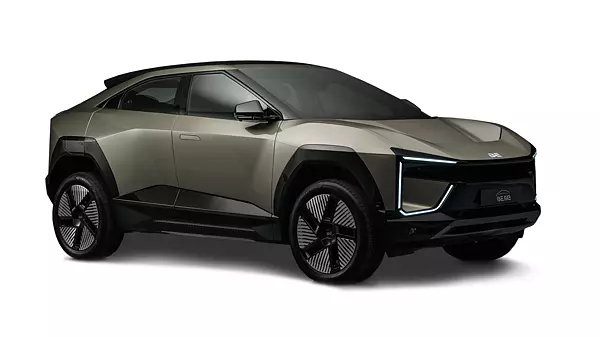

In [3]:
from PIL import Image

img = Image.open("/datalab/be-6e-exterior-right-front-three-quarter-5.webp")

img

In [ ]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))

vision_model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass


from torchvision import transforms

def preprocess_image(image, image_size=224):
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    image_tensor = preprocess(image)
    #(3, 224, 224) --> unsqueeze --> (1, 3, 224, 224)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

image_tensor = preprocess_image(img)

embed_dim = 768
patch_size = 16
image_size = 224
num_patches = (image_size // patch_size) ** 2

with torch.no_grad():
    patch_embedding = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
    patches = patch_embedding(image_tensor)

patches.shape, num_patches

(torch.Size([1, 768, 14, 14]), 196)

In [5]:
position_embedding = nn.Embedding(num_patches, embed_dim)
position_ids = torch.arange(num_patches).expand((1, -1))

position_ids.shape

torch.Size([1, 196])

In [6]:
# after flatten (1, 768, 196)
embeddings = patches.flatten(start_dim=2, end_dim=-1)
# (1, 768, 196) -> (1, 196, 768)
embeddings = embeddings.transpose(1,2)

embeddings = embeddings + position_embedding(position_ids)

embeddings.shape

torch.Size([1, 196, 768])

In [8]:
import matplotlib.pyplot as plt

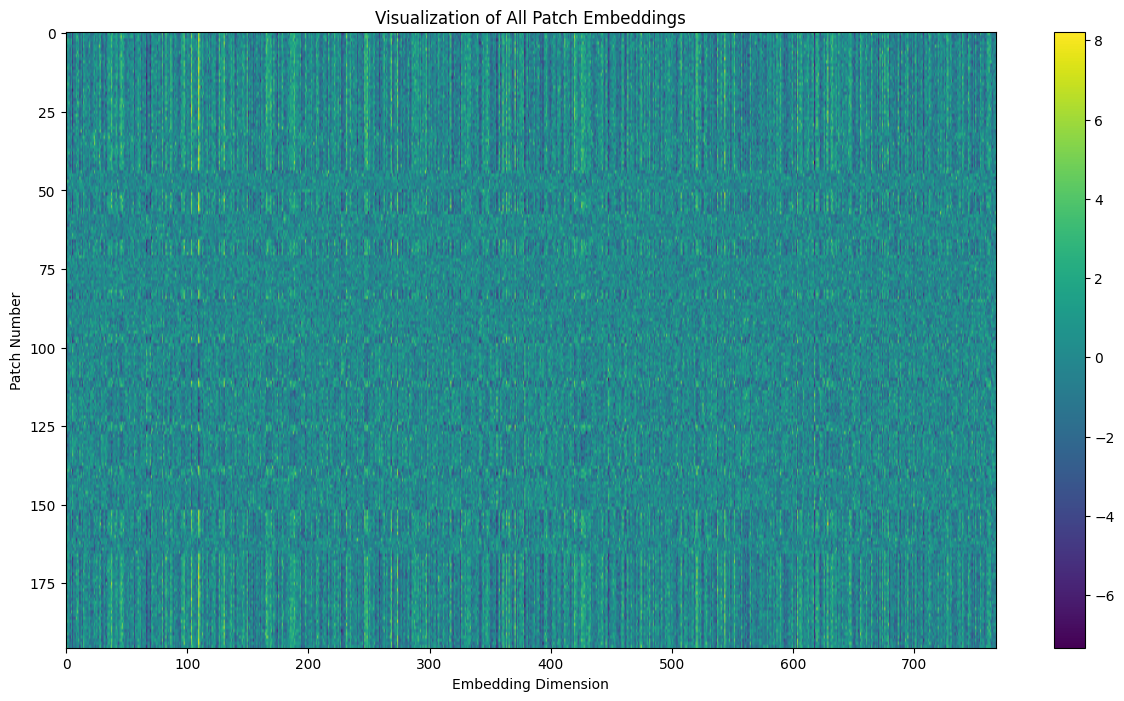

In [9]:
# it should look all random, since the weights are random at the initialization
# Visualize all patch embeddings
patches_viz = embeddings[0].detach().numpy()  # Shape: [196, 768]

plt.figure(figsize=(15, 8))
plt.imshow(patches_viz, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Visualization of All Patch Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Patch Number')
plt.show()

In [11]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig

processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", config=SiglipVisionConfig(vision_use_head=False))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

torch.Size([1, 196, 768])


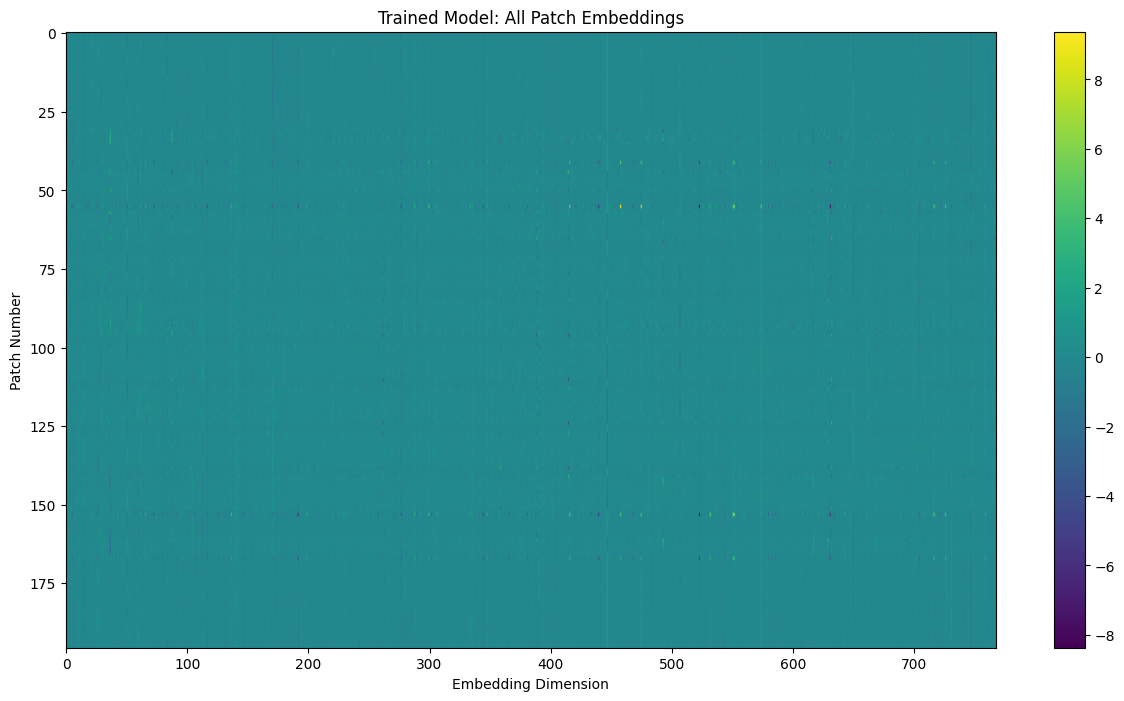

In [12]:
vision_model.eval()
inputs = processor(images=img, return_tensors="pt")

with torch.no_grad():
    patch_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)

print(patch_embeddings.shape)

patches_viz = patch_embeddings[0].detach().numpy()  # Shape: [196, 768]

plt.figure(figsize=(15, 8))
plt.imshow(patches_viz, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Trained Model: All Patch Embeddings')
plt.xlabel('Embedding Dimension')
plt.ylabel('Patch Number')
plt.show()

In [13]:
@dataclass
class SiglipVisionConfig:
  num_channels: int = 3
  embed_dim: int = 768
  image_size: int = 224
  patch_size: int = 16

class SiglipVisionEmbeddings(nn.Module):
  def __init__(self, config: SiglipVisionConfig):
    super().__init__()
    self.config = config

    self.num_channels = config.num_channels
    self.embed_dim = config.embed_dim
    self.image_size = config.image_size
    self.patch_size = config.patch_size

    self.patch_embedding = nn.Conv2d(
      in_channels=self.num_channels,
      out_channels=self.embed_dim,
      kernel_size=self.patch_size,
      stride=self.patch_size,
      padding="valid",
    )

    self.num_patches = (self.image_size // self.patch_size) ** 2
    self.num_positions = self.num_patches
    self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
    self.register_buffer(
      "position_ids",
      torch.arange(self.num_positions).expand((1, -1)),
      persistent=False,
    )

  def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
    B, C, H, W = pixel_values.shape

    patch_embeds = self.patch_embedding(pixel_values)
    embeddings = patch_embeds.flatten(start_dim=2, end_dim=-1)
    embeddings = embeddings.transpose(1, 2)
    embeddings = embeddings + self.position_embedding(self.position_ids)
    return embeddings

In [14]:
embd = SiglipVisionEmbeddings(SiglipVisionConfig())
embd(image_tensor).shape

torch.Size([1, 196, 768])

In [15]:
from transformers import SiglipVisionModel as HFSiglipVisionModel

our_state_dict = embd.state_dict()
hf_state_dict = {k.replace("vision_model.embeddings.", ""): v for k, v in vision_model.state_dict().items() if "vision_model.embeddings." in k}
our_state_dict.update(hf_state_dict)
embd.load_state_dict(our_state_dict)

with torch.no_grad():
    our_output = embd(image_tensor)
    hf_output = vision_model.vision_model.embeddings(image_tensor)
    print("Max difference between our output and HF output:", torch.max(torch.abs(our_output - hf_output))) # =0, so they match!

Max difference between our output and HF output: tensor(0.)


In [16]:
import math

class Head(nn.Module):
    """ A single head of the multi-head attention """

    def __init__(self, n_in, n_head, context_length):
        super().__init__()
        self.head_size = n_head
        self.key = nn.Linear(n_in, n_head, bias=False)
        self.query = nn.Linear(n_in, n_head, bias=False)
        self.value = nn.Linear(n_in, n_head, bias=False)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
        wei = F.softmax(wei, dim=-1)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """ Multi-head attention implementation with concatenating every head's output"""

    def __init__(self, num_head, n_in, head_size, context_length):
        super().__init__()
        self.head_size = head_size
        self.num_head = num_head
        self.heads = [Head(n_in, head_size, context_length) for _ in range(num_head)]
        self.proj = nn.Linear(n_in, n_in)


    def forward(self, x):
        out = [h(x) for h in self.heads]
        out = torch.concat(out, -1)
        out = self.proj(out)
        return out



In [17]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0

class SiglipAttention(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, hidden_states):
        # the hidden states are the embeddings of the patches, so (batch_size, num_patches, embed_dim)
        B, T, C = hidden_states.shape
        q_states = self.q_proj(hidden_states)
        k_states = self.k_proj(hidden_states)
        v_states = self.v_proj(hidden_states)

        q_states = q_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        k_states = k_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        v_states = v_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)

        attn_weights = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))
        attn_weights = F.softmax(attn_weights, dim=-1).to(q_states.dtype)
        attn_weights = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_outs = attn_weights @ v_states
        attn_outs = attn_outs.transpose(1, 2)
        attn_outs = attn_outs.reshape(B, T, C).contiguous()
        attn_outs = self.out_proj(attn_outs)
        return attn_outs

batch_size = 1
num_patches = 196
embed_dim = 768

hidden_states = torch.randn(batch_size, num_patches, embed_dim)
config = SiglipVisionConfig(
    attention_dropout=0.0,
    num_attention_heads=12,
    hidden_size=768
)
attention = SiglipAttention(config)
output = attention(hidden_states)

print(f"Input shape: {hidden_states.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 196, 768])
Output shape: torch.Size([1, 196, 768])


In [18]:
hf_state_dict = vision_model.vision_model.state_dict()
our_state_dict = attention.state_dict()

key_mapping = {
    'k_proj.weight': 'encoder.layers.0.self_attn.k_proj.weight',
    'k_proj.bias': 'encoder.layers.0.self_attn.k_proj.bias',
    'v_proj.weight': 'encoder.layers.0.self_attn.v_proj.weight',
    'v_proj.bias': 'encoder.layers.0.self_attn.v_proj.bias',
    'q_proj.weight': 'encoder.layers.0.self_attn.q_proj.weight',
    'q_proj.bias': 'encoder.layers.0.self_attn.q_proj.bias',
    'out_proj.weight': 'encoder.layers.0.self_attn.out_proj.weight',
    'out_proj.bias': 'encoder.layers.0.self_attn.out_proj.bias'
}

for our_key, hf_key in key_mapping.items():
    our_state_dict[our_key].copy_(hf_state_dict[hf_key])

attention.load_state_dict(our_state_dict)

with torch.no_grad():
    our_output = attention(hidden_states)
    hf_output = vision_model.vision_model.encoder.layers[0].self_attn(hidden_states)[0]
    max_diff = torch.max(torch.abs(our_output - hf_output))
    print(f"Max difference between our output and HF output: {max_diff:.6f}")
    print((torch.isclose(our_output, hf_output, atol=1e-6)==0).sum())

Max difference between our output and HF output: 0.000001
tensor(0)


In [19]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0
    intermediate_size: int = 3072

class SiglipMLP(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        hidden_states = self.fc2(hidden_states)
        return hidden_states

mlp = SiglipMLP(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
mlp(torch.randn(1, 196, 768)).shape


torch.Size([1, 196, 768])

In [20]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768 # `embed_dim` --> `hidden_size`, just renamed it.
    attention_dropout: float = 0.0
    intermediate_size: int = 3072
    layer_norm_eps: float = 1e-6

class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config

        self.num_channels = config.num_channels
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size, # there won't be any overlapping since the stride is equal to the kernel size
            padding="valid",
        )
        self.num_patches = (self.image_size // self.patch_size) ** 2 # initially the images are square, so the patch sizes.
        self.num_positions = self.num_patches # this is the number of positions in the sequence
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer( # this is a buffer for the position ids, which will be a tensor of shape [1, num_patches]
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False, # this is a buffer, so it won't be updated during the forward pass
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        B, C, H, W = pixel_values.shape
        patch_embeds = self.patch_embedding(pixel_values)
        embeddings = patch_embeds.flatten(start_dim=2, end_dim=-1)
        embeddings = embeddings.transpose(1, 2)
        embeddings = embeddings + self.position_embedding(self.position_ids) # [batch_size, # patches, embed_dim]
        return embeddings

In [21]:
class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)


    def forward(self, hidden_states):
        residual = hidden_states
        hidden_states = self.layer_norm1(hidden_states)
        hidden_states = self.self_attn(hidden_states)
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states
        return hidden_states

encoder_layer = SiglipEncoderLayer(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
encoder_layer(torch.randn(1, 196, 768)).shape

torch.Size([1, 196, 768])

In [22]:
vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

In [23]:
@dataclass
class SiglipVisionConfig:
    num_hidden_layers: int = 12 # number of hidden layers in the encoder as in the paper
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    intermediate_size: int = 3072
    layer_norm_eps: float = 1e-6
    attention_dropout: float = 0.0


class SiglipEncoder(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)])


    def forward(self, hidden_states):
        for layer in self.layers:
            hidden_states = layer(hidden_states)
        return hidden_states

encoder = SiglipEncoder(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
encoder(torch.randn(1, 196, 768)).shape

torch.Size([1, 196, 768])

In [24]:
class SiglipVisionTransformer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, pixel_values):
        hidden_states = self.embeddings(pixel_values)
        last_hidden_state = self.encoder(hidden_states)
        last_hidden_state = self.post_layernorm(last_hidden_state)
        return last_hidden_state

siglip = SiglipVisionTransformer(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
siglip(image_tensor).shape

torch.Size([1, 196, 768])

In [25]:
class SiglipVisionModel(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)

    def forward(self, pixel_values):
        return self.vision_model(pixel_values)

siglip = SiglipVisionModel(SiglipVisionConfig(hidden_size=768, intermediate_size=3072))
siglip(image_tensor).shape

torch.Size([1, 196, 768])

In [26]:
hf_state_dict = vision_model.state_dict()
our_state_dict = siglip.state_dict()

siglip.load_state_dict(hf_state_dict)

<All keys matched successfully>